# Notebook 02 – Text Preprocessing & Feature Preparation

our Goalis:
Prepare the text column for NLP modeling by cleaning, normalizing, and creating features for later use in prediction or analysis.

Input: df_train from Notebook 01 with columns:

case_id

case_no

title

judgment_date

facts

applicants

defendants

allegedly_violated_articles

violated_articles

court_assessment_references

silver_rationales

gold_rationales

text (combined column)

outcome (binary label 0/1)

text_length

In [1]:
import pandas as pd

# Load dataset saved from Notebook 01
df_train = pd.read_csv("/kaggle/input/df-train-csv/df_train.csv")

# Check data
df_train.head(2)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   case_id                      9000 non-null   object
 1   case_no                      9000 non-null   object
 2   title                        9000 non-null   object
 3   judgment_date                9000 non-null   object
 4   facts                        9000 non-null   object
 5   applicants                   9000 non-null   object
 6   defendants                   9000 non-null   object
 7   allegedly_violated_articles  9000 non-null   object
 8   violated_articles            9000 non-null   object
 9   court_assessment_references  9000 non-null   object
 10  silver_rationales            9000 non-null   object
 11  gold_rationales              9000 non-null   object
 12  text                         9000 non-null   object
 13  outcome                      9000

Import important libraries for text preprocessing, cleaning,ect.

In [2]:
#Text Preprocessing

import pandas as pd
import re   # for regex cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# Plot style
#plt.style.use('seaborn')
%matplotlib inline

# Download nltk resources (first time)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# nltk is a Python library for text processing.

stopwords used for common words like “the”, “is”, “and” that don’t add meaning for NLP.

WordNetLemmatizer() used for reduces words to their root form (for example, "running" to root form is  "run").

nltk.download(stopword/punkt/wordnet) - downloads required resources for the first time.

Why we do this:

Stopwords removal reduces noise.

Lemmatization helps NLP models generalize better.

If skipped - text will have redundant words and inflected forms, e.g., “ran” vs “running”, making analysis noisy.

In [3]:
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # remove special characters
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


# Step-by-step explanation

str(text).lower() : ensures the text is a string and converts it to lowercase.

Why? "Court" and "court" should be treated the same.

If skipped : NLP model may think "Court" and "court" are different words.

re.sub(r'[^a-z0-9\s]', ' ', text) : removes everything except letters, numbers, and spaces.

Why? Punctuation like . , ; : doesn’t add meaning in most NLP tasks.

If skipped : model sees unnecessary symbols and may learn wrong patterns.

[lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words] :

text.split() : splits the text into words

if word not in stop_words : removes words like “the”, “and”

lemmatizer.lemmatize(word) : converts word to root form

' '.join() : recombines cleaned words into a single string

Result: clean_text column is cleaned, normalized, ready for NLP.

If skipped:

Raw text may contain punctuation, stopwords, different cases : NLP models will perform poorly.

In [4]:
# Apply cleaning
df_train['clean_text'] = df_train['text'].apply(clean_text)

# Check result
df_train[['text', 'clean_text']].head(2)

,text,clean_text
0,['11. At the beginning of the events relevant...,11 beginning event relevant application k daug...
1,['9. The applicant is the monarch of Liechten...,9 applicant monarch liechtenstein born 1945 li...


# Apply Cleaning 
.apply(clean_text) : applies the function to each row in text.

Creates a new column clean_text so we keep the original text intact.

Why we keep both:

Original text is useful for reference or explainability.

Cleaned text is used for modeling.

In [5]:
# Count words in cleaned text
df_train['clean_text_length'] = df_train['clean_text'].apply(lambda x: len(x.split()))

# Quick stats
print("Text length stats (after cleaning):")
print(df_train['clean_text_length'].describe())
print(df_train['clean_text_length'].info())

Text length stats (after cleaning):
count     9000.000000
mean       913.335444
std       1105.265751
min         46.000000
25%        287.000000
50%        569.000000
75%       1115.000000
max      19604.000000
Name: clean_text_length, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 9000 entries, 0 to 8999
Series name: clean_text_length
Non-Null Count  Dtype
--------------  -----
9000 non-null   int64
dtypes: int64(1)
memory usage: 70.4 KB
None


# Count the word in cleaned text
len(x.split()) : counts number of words in the cleaned text.

.describe() : shows mean, min, max, quartiles.

Why we do this:

Helps us understand if some cases are extremely short or long.

Outliers (very short/long cases) may need special handling in models.

If skipped:

You won’t know your text distribution : may affect feature engineering and model performance.

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten list of violated_articles
def flatten_articles(articles):
    if isinstance(articles, str):
        try:
            # Convert string representation of list back to list
            import ast
            articles = ast.literal_eval(articles)
        except:
            return []
    if isinstance(articles, list):
        return articles
    return []

all_articles = df_train['violated_articles'].apply(flatten_articles).sum()
article_counter = Counter(all_articles)
# Top 10 most frequent
top_articles = article_counter.most_common(10)
print("Top 10 Violated Articles:")
for art, count in top_articles:
    print(f"{art}: {count}")

Top 10 Violated Articles:
6: 4704
P1-1: 1421
5: 1368
3: 1349
13: 1238
8: 710
2: 505
10: 291
14: 141
11: 110


ast.literal_eval : converts strings like "['8', '13']" back to Python lists.

Why? violated_articles is stored as list in a string, so we must convert it to count properly.

.sum() : flattens all lists into one big list of articles.

Counter(all_articles) : counts frequency of each article.

If skipped:

You cannot count most frequent articles because the column contains list objects, not plain strings.

Counter would throw TypeError: unhashable type: 'list'.

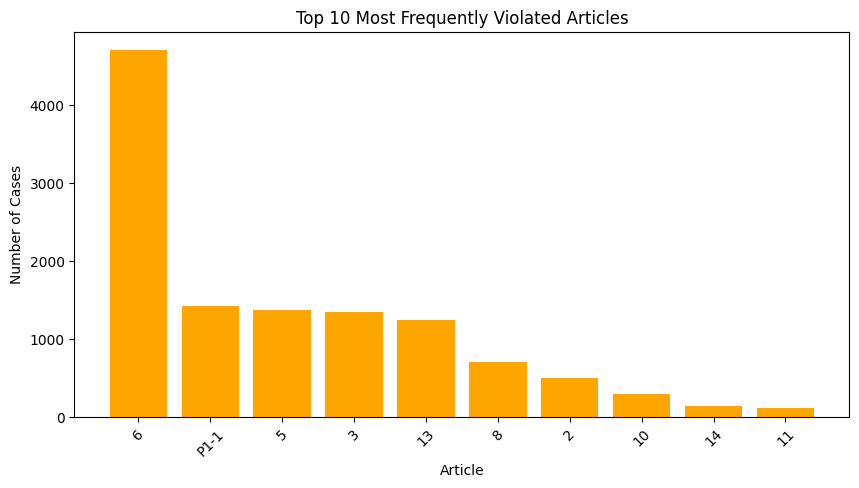

In [10]:
# Plot
articles, counts = zip(*top_articles)
plt.figure(figsize=(10,5))
plt.bar(articles, counts, color='orange')
plt.title("Top 10 Most Frequently Violated Articles")
plt.xlabel("Article")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.show()

# most_common(10) : gets top 10 frequent articles.

zip(*top_articles) : separates article names and counts for plotting.

plt.bar() : creates bar chart.

.xticks(rotation=45) : rotates labels for readability.

Why we do this:

Visualizes which laws are most often violated : insights for reports, portfolios.

If skipped : you miss a key exploratory analysis step.

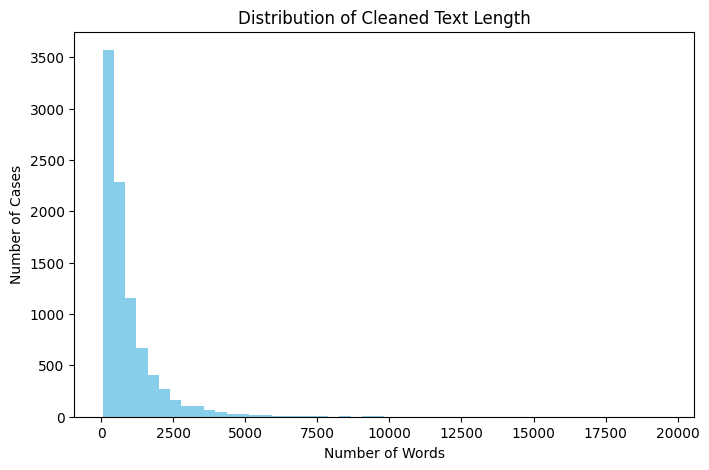

In [11]:
plt.figure(figsize=(8,5))
plt.hist(df_train['clean_text_length'], bins=50, color='skyblue')
plt.title("Distribution of Cleaned Text Length")
plt.xlabel("Number of Words")
plt.ylabel("Number of Cases")
plt.show()

.hist() : histogram of word counts

Helps understand case length distribution

Why we do this:

Identify outliers (very short or very long texts)

Decide preprocessing or truncation for models

In [12]:
df_train.to_csv("/kaggle/working/df_train_cleaned.csv", index=False)
print("Cleaned dataset saved! Ready for modeling in Notebook 03.")


Cleaned dataset saved! Ready for modeling in Notebook 03.


# Saves the preprocessed dataset for Notebook 03 (modeling).

index=False : avoids saving row numbers as a separate column

Why we do this:

Keeps Notebook workflow modular

Ensures reproducibility

If skipped:

You’d have to redo cleaning every time : waste of time and errors may occur.